# The lpfics module: practical application

Energy system modeling can be done by the means of mathematical programming. Mathematical programs enable modelers to represent energy systems and to optimize operation and possibly design decisions. The corresponding optimisation problem is defined by an objective and a set of constraints. Cases of infeasible problems can happen. This notebook presents the lpfics (Linear Problem: Find Infeasible Constraint Set) python module which includes an algorithm developped to identify constraints that make the porblem infeasible. The application example is based on an energy project.

This is the updated version of the notebook first created by L. Morriet, now deprecated (https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_notebooks/-/blob/master/notebooks/article_2020_IBPSA_constraint_identification.ipynb). It has been updated by Etienne Cuisinier, inspired by the ORUCE method from Sacha Hodencq (S. Hodencq, « Méthodes et outils pour un processus de modélisation collaboratif et ouvert des systèmes énergétiques », Energ. Électr. Univ. Grenoble Alpes, 2022, doi: tel-03809331.)



## 1) General information

- Licence: [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html), Copyright 2018 G2Elab / MAGE*

- This notebook is linked to the following scientific conference article : L. Morriet, B. Delinchant, G. Debizet, F. Wurtz *Algorithme d’identification de contraintes incompatibles pour les problèmes d’optimisation : application à un projet énergétique*, Conférence IBPSA France – Reims, 2020.

- The lpfics module is applied on a model built with the [OMEGAlpes](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes) modeling tool , version 0.4.2. It is a linear optimization tool designed to easily generate multi-carrier energy system models. OMEGAlpes is developped by the MAGE team of the G2ELab, under the licence [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html).

- The lpfics module is developped by the MAGE team of the G2ELab. 

*Related research:*
- L. Morriet, « Conception multiacteur de systèmes énergétiques locaux bas-carbone: outils, modèles et analyses qualitatives », p. 294.
- L. Morriet, G. Debizet, et F. Wurtz, « Multi-Actor Modelling For MILP Energy Systems Optimisation: Application To Collective Self-Consumption », Rome, Italy, p. 2872‑2879. doi: 10.26868/25222708.2019.210472.

>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fomegalpes%2Fomegalpes_examples/HEAD?labpath=%2Fnotebooks%2Farticle_2020_IBPSA_constraint_identification_UPDATE.ipynb)

>You can then easily use this Jupyter notebook by runnning each cell with the Run ("Exécuter" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file.


## 2) Description of the case study

The following figure is a graphical representation of the model used for the project. It is further described below.

![OMEGAlpes graphical representation of the case study](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/raw/master/notebooks/figures/lpfics.PNG)

The study will carry from the 11th to the 17th of May 2019. The project is based on three dwellings located at the end of an instable electrical network in rural area. These dewllings have electrical consumptions (*Elec_consumption_1,2,3*) and heat consumption for domestic hot water consumption (*Heat_consumption_1,2,3*). The inhabitants (the *Prosumer*) want to produce their own local energy production based on PV (Photovoltaic) pannels (*Local_pv_production*) installed in their houses and annex-building roofs. After a short study of the available space, they consider: 
- Scenario 1: that they can install at maximum 50 kWc (*ACte: prosumer_max_pv*)
- Scenario 2: that they will install 50 kWc (*ACte: prosumer_number_pv*)

Furthermore, they consider that:
- Electrical devices will be connected to the network (*Elec_recovery*, *Elec_supply*)
- They will have their own heat pump (*Heat_pump*). The pump is linked to the heat node of each heat consumptions. To improve the durability of the heat pump, they decided to let the heat pump last for at least one hour once it is started-up (*DCte: heat_pump_elec_cons_set_min_up_time*).

Finally, we also consider the case where the Supplier forbids the injection of electricity from the Prosumer to the network (*ACte: no_injection*).



### Packages to import:


In [1]:
import os


# ------------------------------------------------------------------------------OMEGAlpes

# Module version
__version_info__ = (0, 4, 3) ### Please note that this notebook is currently not working with version 0.4.4., it will work with version 0.4.5.
__version__ = ".".join(str(x) for x in __version_info__)

# Documentation strings format
__docformat__ = "restructuredtext en"

# Install corresponding omegalpes version
os.system('pip install omegalpes==' + __version__)

# -----------------------------------------------------------------------------PULP

# Module version
__version_info__ = (2, 6, 0)
__version__ = ".".join(str(x) for x in __version_info__)

# Install corresponding pulp version
os.system('pip install pulp==' + __version__)

# -----------------------------------------------------------------------------lpfics

os.system('pip install lpfics')


from pulp import LpStatus

from omegalpes.actor.operator_actors.prosumer_actors import Prosumer
from omegalpes.actor.operator_actors.supplier_actors import Supplier
from omegalpes.energy.energy_nodes import EnergyNode

from omegalpes.general.optimisation.model import OptimisationModel, compute_gurobi_IIS
from omegalpes.general.time import TimeUnit
from lpfics import lpfics
import time as pytime
from matplotlib.pyplot import subplots
from omegalpes.energy.units.production_units import VariableProductionUnit, SeveralProductionUnit
from omegalpes.energy.units.consumption_units import VariableConsumptionUnit, FixedConsumptionUnit
from omegalpes.energy.units.conversion_units import HeatPump
from omegalpes.general.utils.plots import plt, plot_node_energetic_flows
from omegalpes.general.utils.input_data import read_enedis_data_csv_file



DEPRECATED: please now use SingleConversionUnit with relevant energytypes


## 3) Data
3 sets of time-dependant data are used for this illustrative case. 

**One for the PV production (*Local_pv_prodution*):**
It corresponds to the PV production (W) for 11-17 may 2016 from PVGIS (year 2019 was not available).
7 days are represented with half-an-hour time step.
It was downloaded from https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html#HR (hourly data, then divided by two to convert it into half-an-hour data).
With the following parameters :
- Solar radiation data: PVGIS-SARAH;
- Start and end year: 2019;
- Mounting type: Fixed;
- Slope 15°;
- Azimuth 0°;
- PV power;
- PV technology: crystalline silicon;
- Installed peak PV power: 0.250 kWc;
- System loss: 0%

|#|Key |Parameter |
|---|---|---|
| 1 | name | Timeseries_45.173_5.724_SA_0.250kWp_crystSi_0_15deg_0deg_2016_2016.csv|
| 2 | title |PV production| 
| 3 | id | |
| 4 | description | PV production (W) for 11-17 may 2016 from PVGIS |
| 5 | language | |
| 6 | subject |  |
| 7 | keywords | |
| 8 | publicationDate | 15/10/2019 (last update)|
| 9 | context | |
| 10 | spatial |France, GPS coordinates| 
| 11 | temporal | 7 days are represented with half-an-hour time step|
| 12 | source |https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html#HR |
| 13 | licenses |  [Creative Commons Attribution 4.0 International (CC BY 4.0) licence](https://creativecommons.org/licenses/by/4.0/) |
| 14 | contributors | European Commission |
| 15 | resources |[PVGIS user manual](https://joint-research-centre.ec.europa.eu/pvgis-photovoltaic-geographical-information-system/getting-started-pvgis/pvgis-user-manual_en) |

**One for the electrical loads (*Elec_load_1,2,3*):**
It corresponds to the electrical consumption (W) of a dwelling for 11-17 may 2019 from Enedis.
7 days are represented with half-an-hour time step.
It was downloaded from https://www.enedis.fr/agregats-segmentes-de-consommation-et-production-electriques-au-pas-12-h.
With the following parameters :
- Consommation <36kVA;
- Courbe moyenne : Wh;
- Sélectionner le national ou une région : Auvergne-Rhône-Alpes;
- Profil : RES1 (+RES1WE);
- Plage de puissance souscrite: P2:]3-6kVA]

|#|Key |Parameter |
|---|---|---|
| 1 | name | Dwelling_elec_consumption_3-6kVA_11-17-2019.txt|
| 2 | title |Electrical consumption| 
| 3 | id | |
| 4 | description | Electrical consumption (W) of a dwelling for 11-17 may 2019 from Enedis |
| 5 | language | |
| 6 | subject |  |
| 7 | keywords | |
| 8 | publicationDate | 2020|
| 9 | context | |
| 10 | spatial |France, residential scale | 
| 11 | temporal | 7 days are represented with half-an-hour time step |
| 12 | source |https://www.enedis.fr/agregats-segmentes-de-consommation-et-production-electriques-au-pas-12-h |
| 13 | licenses |  Open license v2.0 (Etalab) |
| 14 | contributors | [Enedis](https://data.enedis.fr/pages/accueil) |
| 15 | resources |[Enedis Open data](https://www.enedis.fr/open-data) |

**One for heat loads (*Heat_load_1,2,3*):**
It corresponds to heat consumption (W) for domestic hot water use. It was chosen arbitrarily. 7 days are represented with half-an-hour time step.


###  Data imports:

Data series are hard-coded here.

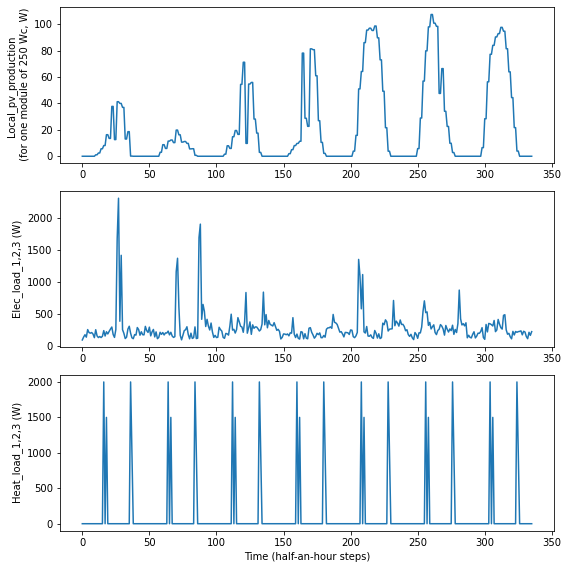

In [2]:
pv_production=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.08, 1.08, 2.46, 2.46, 5.66, 5.66, 8.11, 8.11, 16.32, 16.32, 13.5, 13.5, 37.75, 37.75, 12.61, 12.61, 41.3, 41.3, 40.01, 40.01, 37.0, 37.0, 13.04, 13.04, 18.63, 18.63, 0.12, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.01, 3.01, 8.75, 8.75, 5.91, 5.91, 11.47, 11.47, 12.29, 12.29, 10.32, 10.32, 19.82, 19.82, 16.24, 16.24, 10.7, 10.7, 11.17, 11.17, 9.74, 9.74, 5.57, 5.57, 5.69, 5.69, 0.7, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.57, 1.57, 7.93, 7.93, 5.91, 5.91, 14.76, 14.76, 19.49, 19.49, 16.54, 16.54, 54.43, 54.43, 71.19, 71.19, 9.73, 9.73, 54.67, 54.67, 55.89, 55.89, 28.16, 28.16, 17.53, 17.53, 2.93, 2.93, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.95, 1.95, 4.97, 4.97, 8.08, 8.08, 9.72, 9.72, 11.36, 11.36, 78.1, 78.1, 28.78, 28.78, 22.64, 22.64, 81.33, 81.33, 80.69, 80.69, 60.95, 60.95, 26.92, 26.92, 10.51, 10.51, 2.19, 2.19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.86, 3.86, 15.83, 15.83, 50.98, 50.98, 64.19, 64.19, 86.04, 86.04, 95.53, 95.53, 97.0, 97.0, 95.24, 95.24, 98.63, 98.63, 89.67, 89.67, 73.01, 73.01, 49.24, 49.24, 21.6, 21.6, 3.82, 3.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.81, 5.81, 28.94, 28.94, 56.93, 56.93, 79.81, 79.81, 97.97, 97.97, 107.35, 107.35, 100.77, 100.77, 98.37, 98.37, 47.57, 47.57, 66.38, 66.38, 34.06, 34.06, 22.58, 22.58, 9.86, 9.86, 2.82, 2.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.51, 6.51, 28.4, 28.4, 56.36, 56.36, 77.21, 77.21, 83.99, 83.99, 90.35, 90.35, 92.88, 92.88, 97.61, 97.61, 94.7, 94.7, 81.42, 81.42, 63.91, 63.91, 44.4, 44.4, 21.69, 21.69, 3.92, 3.92, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
elec_consumption=[96, 142, 178, 140, 258, 212, 202, 212, 188, 132, 256, 160, 134, 150, 134, 154, 242, 158, 224, 190, 230, 266, 298, 182, 136, 260, 1670, 2306, 388, 1416, 256, 200, 118, 140, 266, 310, 202, 130, 116, 180, 172, 290, 258, 170, 224, 178, 176, 308, 242, 214, 296, 160, 222, 260, 144, 222, 116, 136, 216, 184, 212, 174, 206, 204, 234, 176, 216, 158, 136, 148, 1160, 1370, 608, 168, 98, 172, 242, 256, 302, 180, 114, 202, 120, 132, 300, 118, 124, 1692, 1902, 418, 650, 544, 306, 418, 312, 252, 360, 222, 136, 168, 134, 138, 294, 258, 234, 136, 122, 198, 192, 172, 312, 498, 250, 262, 204, 258, 444, 380, 310, 298, 216, 380, 836, 202, 284, 378, 184, 332, 278, 300, 298, 270, 236, 258, 344, 842, 332, 492, 286, 400, 340, 326, 314, 366, 306, 246, 262, 230, 112, 136, 190, 188, 178, 190, 160, 208, 202, 444, 186, 134, 188, 122, 110, 226, 218, 114, 194, 124, 114, 280, 288, 216, 174, 124, 152, 200, 180, 206, 132, 132, 166, 140, 264, 284, 286, 300, 278, 494, 372, 362, 338, 278, 218, 226, 190, 144, 214, 212, 208, 182, 252, 248, 148, 132, 160, 214, 1352, 1092, 582, 1116, 222, 204, 306, 158, 154, 176, 136, 120, 244, 200, 126, 192, 118, 132, 358, 334, 410, 378, 236, 264, 268, 270, 712, 318, 390, 360, 312, 408, 338, 340, 306, 240, 256, 180, 152, 184, 130, 102, 212, 182, 122, 208, 206, 298, 544, 706, 522, 534, 324, 370, 268, 302, 332, 212, 180, 244, 264, 336, 312, 266, 172, 322, 264, 220, 268, 242, 326, 184, 260, 212, 352, 874, 426, 330, 350, 316, 364, 130, 170, 138, 128, 184, 224, 128, 156, 202, 200, 228, 288, 134, 106, 338, 222, 354, 348, 334, 314, 400, 226, 252, 416, 344, 288, 266, 480, 490, 254, 186, 200, 146, 114, 230, 174, 228, 216, 226, 230, 238, 176, 232, 220, 150, 116, 216, 168, 226]
heat_consumption=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 0.0, 1500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 0.0, 1500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 0.0, 1500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 0.0, 1500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 0.0, 1500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 0.0, 1500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 0.0, 1500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

fig, axs = subplots(3, 1, figsize=(8,8))
axs[0].plot(pv_production)
axs[0].set_ylabel('Local_pv_production \n (for one module of 250 Wc, W)')
axs[1].plot(elec_consumption)
axs[1].set_ylabel('Elec_load_1,2,3 (W)')
axs[2].plot(heat_consumption)
axs[2].set_ylabel('Heat_load_1,2,3 (W)')
axs[2].set_xlabel('Time (half-an-hour steps)')
fig.tight_layout()
plt.show()




## 4) Modelling method

The case study is modelled with OMEGAlpes. OMEGAlpes is modelling tool based on the mixed-integer mathematical programming (MILP) formalism. Several references can be listed:
- General information: https://openenergy-platform.org/factsheets/models/198/. 
- Reference scientific publication : S. Hodencq, M. Brugeron, J. Fitó, L. Morriet, B. Delinchant, et F. Wurtz, « OMEGAlpes, an Open-Source Optimisation Model Generation Tool to Support Energy Stakeholders at District Scale », Energies, vol. 14, no 18, p. 5928, sept. 2021, doi: 10.3390/en14185928.
- Source code : https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes


### Assumptions
The real life problem is supposed to be perfectly described by the MILP problem built with OMEGAlpes. This MILP problem describes dynamically production, import, export, consumption, and conversion energy quantities over one week, with half-an-hour time steps. No economic quantities are considered. 
- Each energy node represents an energy balance equation applied at each time step (energy in = energy out). 
- The PV production of a module, the heat and the electricity consumptions are supposed perfectly described by the data series imported above and perfectly known in advance. Consumptions have to be satisfied exactly at each time step.
- The amount of energy imported/exported is unlimited at each time step (except if the Supplier's constraint is activated)
- The heat pump has unlimited power capacity, no losses and a constant COP (Coefficient Of Performances) of 3. 
- The number of PV modules is either fixed to 200 (Scenario 2) or an optimization variable set inferior to 200 (Scenario 1).

The detailed formulation of the problem can be found by looking at the OMEGAlpes source code and/or looking at the lp file generated by OMEGAlpes.


## 5) Scenario 1

### 5.1) Modelling process with OMEGAlpes

#### 5.1.1) Creating units

In [3]:
## Time configuration : 336 periods of half-an-hour (1 week)
time = TimeUnit(periods=24 * 7 * 2, dt=0.5)

## Dwelling electrical and heat consumption.
## The FixedConsumptionUnit module is used: consumptions are determined by the data series, they are not optimization variables.
## Each dwelling has the same consumption: defined by the data series previously imported.

# Dwelling 1 : Elec_consumption_1 and Heat_consumption_1 #
elec_consumption_1 = FixedConsumptionUnit(time, name='Elec_consumption_1',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_1 = FixedConsumptionUnit(time, name='Heat_consumption_1',
                        p=heat_consumption, energy_type='Thermal')

# Dwelling 2 : Elec_consumption_2 and Heat_consumption_2 #
elec_consumption_2 = FixedConsumptionUnit(time, name='Elec_consumption_2',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_2 = FixedConsumptionUnit(time, name='Heat_consumption_2',
                        p=heat_consumption, energy_type='Thermal')

# Dwelling 3 : Elec_consumption_3 and Heat_consumption_3 #
elec_consumption_3 = FixedConsumptionUnit(time, name='Elec_consumption_3',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_3 = FixedConsumptionUnit(time, name='Heat_consumption_3',
                        p=heat_consumption, energy_type='Thermal')

## PV production (Local_pv_production)
## The module SeveralProductionUnit is used in order to have the possibility to have several units of 250 kWc. 
## The production of each module is given by the data series previously imported. 
local_pv_production = SeveralProductionUnit(time=time,
                                            name='Local_pv_production',
                                            fixed_prod=pv_production,
                                            energy_type='Electrical')

## Heat-pump 
heat_pump = HeatPump(time=time, name='Heat_pump')

## Network (Elec_supply, Elec_recovery)
elec_supply = VariableProductionUnit(time=time, name='Elec_supply',
                                     energy_type='Electrical')
elec_recovery = VariableConsumptionUnit(time=time,
                                        name='Elec_recovery',
                                        energy_type='Electrical')


You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:30:00
Creating the Elec_consumption_1.
Creating the Heat_consumption_1.
Creating the Elec_consumption_2.
Creating the Heat_consumption_2.
Creating the Elec_consumption_3.
Creating the Heat_consumption_3.
Creating the Local_pv_production.
Creating the Heat_pump_therm_prod.
Creating the Heat_pump_therm_cons.
Creating the Heat_pump_elec_cons.
Creating the Heat_pump.
Creating the Elec_supply.
Creating the Elec_recovery.


#### 5.1.2) Connecting units through nodes:

In [4]:
## Electrical node
# Creating the electrical nodes for the energy flows repartition
elec_node = EnergyNode(time=time, name='Elec_node',
                       energy_type='Electrical')

# Connecting units to the node #
elec_node.connect_units(elec_consumption_1,
                        heat_pump.elec_consumption_unit,
                        elec_consumption_2,
                        elec_consumption_3,
                        local_pv_production,
                        elec_supply, elec_recovery)

## Heat node
# Creating heat nodes for each dwelling linked to the heat pump, connected the heat pump and the dwelling to the node

# Dwelling 1
heat_node_dwelling1 = EnergyNode(time=time, name='Heat_node_dwelling1',
                                 energy_type='Thermal')
heat_node_dwelling1.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_1)

# Dwelling 2
heat_node_dwelling2 = EnergyNode(time=time, name='Heat_node_dwelling2',
                                 energy_type='Thermal')
heat_node_dwelling2.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_2)

# Dwelling 3
heat_node_dwelling3 = EnergyNode(time=time, name='Heat_node_dwelling3',
                                 energy_type='Thermal')
heat_node_dwelling3.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_3)

Creating the Elec_node.
Creating the Heat_node_dwelling1.
Creating the Heat_node_dwelling2.
Creating the Heat_node_dwelling3.


#### 5.1.3) Creating actors with areas of responsibility:

In [5]:
## Creating the actors involved in the project
prosumer = Prosumer(name='Prosumer',
                     operated_consumption_unit_list=[elec_consumption_1,
                                                     elec_consumption_2,
                                                     elec_consumption_3],
                     operated_production_unit_list=[local_pv_production],
                     operated_storage_unit_list=[])

supplier = Supplier(name='Supplier',
                    operated_consumption_unit_list=[elec_recovery],
                    operated_production_unit_list=[elec_supply])

## Adding actor's constraints 

# The supplier does not want any injection on the network
supplier.add_energy_collected_maximum(max_e_tot=0,cst_operated_unit_list=[elec_recovery])

# The prosumer wants the heat pump to fonction at least 1 hour once it is started-up (2 time steps of half-an-hour).
heat_pump.elec_consumption_unit._add_min_time_on(min_time_on=2)

# Scenario 1: the prosumers want at maximum 200 modules of 250Wc PV pannels corresponding to around 50kWc
prosumer.add_nb_unit_maximum(nb_unit_max=200,energy_unit=local_pv_production)

## Adding actors' objectives 

# The prosumer wants to maximise its production
prosumer.maximize_production(obj_operated_unit_list=[local_pv_production])

print("\n - - - - - ACTORS OBJECTIVES & CONSTRAINTS - - - - - ")
print("Supplier constraints: {}".format(supplier.get_constraints_name_list()))
print("Supplier objectives: {}".format(supplier.get_objectives_name_list()))
print("Prosumer constraints: {}".format(prosumer.get_constraints_name_list()))
print("Prosumer objectives: {}".format(prosumer.get_objectives_name_list()))

Creating the Prosumer.
Creating the Supplier.

 - - - - - ACTORS OBJECTIVES & CONSTRAINTS - - - - - 
Supplier constraints: ['collected_energy_max_Elec_recovery']
Supplier objectives: []
Prosumer constraints: []
Prosumer objectives: []


#### 5.1.4)  Creating the model and solving


--- Adding all variables to the model ---
Adding variable : Elec_consumption_1_p
Adding variable : Elec_consumption_1_e_tot
Adding variable : Heat_pump_elec_cons_p
Adding variable : Heat_pump_elec_cons_e_tot
Adding variable : Heat_pump_elec_cons_u
Adding variable : Heat_pump_elec_cons_start_up
Adding variable : Elec_consumption_2_p
Adding variable : Elec_consumption_2_e_tot
Adding variable : Elec_consumption_3_p
Adding variable : Elec_consumption_3_e_tot
Adding variable : Local_pv_production_p
Adding variable : Local_pv_production_e_tot
Adding variable : Local_pv_production_u
Adding variable : Local_pv_production_power_curve
Adding variable : Local_pv_production_nb_unit
Adding variable : Elec_supply_p
Adding variable : Elec_supply_e_tot
Adding variable : Elec_supply_u
Adding variable : Elec_recovery_p
Adding variable : Elec_recovery_e_tot
Adding variable : Elec_recovery_u
Adding variable : Heat_pump_COP
Adding variable : Heat_pump_therm_prod_p
Adding variable : Heat_pump_therm_prod_e_

	Add power from Elec_supply.
	Add power from Elec_recovery.


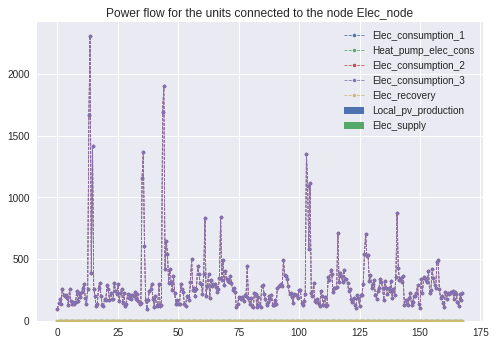


Preparing to plot the energy flows through the node Heat_node_dwelling1.
	Add power from Heat_pump_therm_prod.
	Add power from Heat_consumption_1.


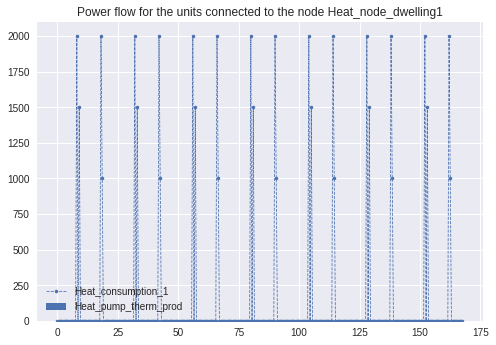

Elec_consumption_1 = 0 kWh.
Elec_consumption_2 = 0 kWh.
Elec_consumption_3 = 0 kWh.
Heat_consumption_1 = 0 kWh.
Heat_consumption_2 = 0 kWh.
Heat_consumption_3 = 0 kWh.
Local_pv_production = 0 kWh
HeatPump consumption = 0 kWh
Elec_supply = 0 kWh
Elec_recovery = 0 kWh


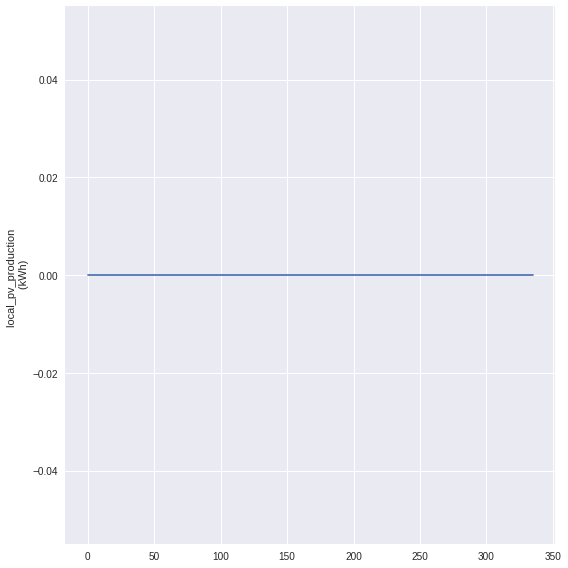

In [6]:
## Creating an empty model
model = OptimisationModel(time=time,name='article_2020_IBPSA_constraints_identification')

## Adding the energy nodes and the actors to the model
model.add_nodes_and_actors(elec_node,
                           heat_node_dwelling1,
                           heat_node_dwelling2,
                           heat_node_dwelling3,
                           prosumer, supplier)

## Run optimization with COIN-CBC solver and update values
model.writeLP('ok.lp')
model.solve_and_update()

print('\n OPTIMIZATION RESULT:', LpStatus[model.status])

## Run optimization with Gurobi solver
# Adding times to evaluate the time of the resolution
# ***ADD OR REMOVE COMMENTS HERE***
# start_solve = pytime.time()
# model.solve(GUROBI_CMD())
# solve_time = pytime.time()
# print('solve_gurobi duration', solve_time -
#       start_solve)

print("Number of pv panels installed = {}".format(local_pv_production.nb_unit))

### 5.2) Infeasible problem : application of the lpfics module

Here the model leads to an unfeasible problem. The lpfics module can be used to reveal a set of constraints that make the problem unfeasible. 

In [7]:
# Adding time to evaluate the time of the identification
LPFICS_start = pytime.time()

# Basic lpfics algorithm
lpfics.find_infeasible_constraint_set(model)

LPFICS_time = pytime.time()
print('LPFICS duration', LPFICS_time - LPFICS_start)


With LPFICS:
Testing if the project is feasible.
If not, finding a set of constraints leading to the infeasibility

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/b175cd941f624e64982697ee5e12bd8c-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/b175cd941f624e64982697ee5e12bd8c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3708 COLUMNS
At line 16346 RHS
At line 20050 BOUNDS
At line 22749 ENDATA
Problem MODEL has 3703 rows, 2698 columns and 9944 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.02 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1065 strengthened rows, 12066 substitutions
Cgl0003I 61 fixed, 1 tightened bounds, 130 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitut

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/db12a17cad8343c09da1b519e9f46f69-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/db12a17cad8343c09da1b519e9f46f69-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3708 COLUMNS
At line 14301 RHS
At line 18005 BOUNDS
At line 21204 ENDATA
Problem MODEL has 3703 rows, 3198 columns and 8241 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.02 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 340 strengthened rows, 0 substitutions
Cgl0004I processed model has 2183 rows, 2014 columns (1006 integer (1006 of which binary)) and 5883 elements
Cbc0045I No integer variables out of 1006 objects (1006 integer) have costs
Cbc0045I branch on satisfied N create fake objective Y random cost Y
Cbc0038I Initial

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/e1163cae02454f0696dabecf93ebf4cc-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/e1163cae02454f0696dabecf93ebf4cc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4171 COLUMNS
At line 16363 RHS
At line 20530 BOUNDS
At line 24066 ENDATA
Problem MODEL has 4166 rows, 3535 columns and 9166 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.02 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 302 strengthened rows, 8 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0004I processed model has 2284 rows, 2058 columns (1305 integer (1305 of which binary)) and 5330 elements
Cbc0045I No integer variables out of 1305 objects (1305 integer) have costs
Cbc0045I b

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/c5e54eccdaba4fef96797bb92f1d8442-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/c5e54eccdaba4fef96797bb92f1d8442-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2319 COLUMNS
At line 7825 RHS
At line 10140 BOUNDS
At line 11905 ENDATA
Problem MODEL has 2314 rows, 1764 columns and 3744 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 6 substitutions
Cgl0004I processed model has 164 rows, 164 columns (82 integer (82 of which binary)) and 328 elements
Cbc0045I No integer variables out of 82 objects (82 integer) have costs
Cbc0045I branch on satisfied N create fake objective Y random cost Y
Cbc0038I Initial state - 0 int

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/07887dbcf96b476892ff43e24f997575-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/07887dbcf96b476892ff43e24f997575-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2319 COLUMNS
At line 8289 RHS
At line 10604 BOUNDS
At line 12369 ENDATA
Problem MODEL has 2314 rows, 1764 columns and 4208 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.03 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 44 strengthened rows, 9 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 307 rows, 289 columns (289 integer (289 of which binary)) and 939 elements
Cbc0045I No integer variables out of 289 objects (289 integer) have costs
Cbc0045I branch on 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/f2c1207f9dc24d05b9075a4811c3ae32-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/f2c1207f9dc24d05b9075a4811c3ae32-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1741 COLUMNS
At line 7017 RHS
At line 8754 BOUNDS
At line 10433 ENDATA
Problem MODEL has 1736 rows, 1678 columns and 3514 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.02 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 49 strengthened rows, 2 substitutions
Cgl0004I processed model has 729 rows, 591 columns (475 integer (475 of which binary)) and 1910 elements
Cbc0045I No integer variables out of 475 objects (475 integer) have costs
Cbc0045I branch on satisfied N create fake objective Y random cost Y
Cbc0038I Initial state - 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/94da154430ef412ea3ebc196b3059f0c-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/94da154430ef412ea3ebc196b3059f0c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1220 COLUMNS
At line 4351 RHS
At line 5567 BOUNDS
At line 6602 ENDATA
Problem MODEL has 1215 rows, 1034 columns and 2199 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.02   (Wallclock seconds):       0.02

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/si

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/ebbe1efa3ba94b2aa3d3a496fa3c25c6-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/ebbe1efa3ba94b2aa3d3a496fa3c25c6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 642 COLUMNS
At line 2362 RHS
At line 3000 BOUNDS
At line 3643 ENDATA
Problem MODEL has 637 rows, 642 columns and 1158 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/f0a42b2088244e63b2ac1d233b985280-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/f0a42b2088244e63b2ac1d233b985280-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 310 COLUMNS
At line 1168 RHS
At line 1474 BOUNDS
At line 1804 ENDATA
Problem MODEL has 305 rows, 329 columns and 552 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-p

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/d58908bef4e040f59aa4e9c1abf2c1e6-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/d58908bef4e040f59aa4e9c1abf2c1e6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 165 COLUMNS
At line 624 RHS
At line 785 BOUNDS
At line 963 ENDATA
Problem MODEL has 160 rows, 177 columns and 291 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-pack

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/67ddd7ff996047d9a4ed15f4d62b10ad-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/67ddd7ff996047d9a4ed15f4d62b10ad-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 85 COLUMNS
At line 315 RHS
At line 396 BOUNDS
At line 482 ENDATA
Problem MODEL has 80 rows, 85 columns and 146 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-package

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/f75ba7fcc133449da115a4db5eaa7466-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/f75ba7fcc133449da115a4db5eaa7466-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 146 RHS
At line 181 BOUNDS
At line 221 ENDATA
Problem MODEL has 34 rows, 39 columns and 69 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/67a23252daa84ff1aeca2cdf6f1851ac-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/67a23252daa84ff1aeca2cdf6f1851ac-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 28 COLUMNS
At line 93 RHS
At line 117 BOUNDS
At line 142 ENDATA
Problem MODEL has 23 rows, 24 columns and 43 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of whi

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/38f010c263e542f5834416a97627ea7c-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/38f010c263e542f5834416a97627ea7c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 20 COLUMNS
At line 62 RHS
At line 78 BOUNDS
At line 94 ENDATA
Problem MODEL has 15 rows, 15 columns and 28 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pu

The lpfics module identifies a set of constraints and indicates for each of them its *type*, *name* and *definition*.
The *type* can refer to "Definition", "Technical", or "Actor" for instance. The term "Dynamic" refers to the fact that this constraint holds for several time steps. 

- Definition constraints are typically energy balances, or constraints that help defining the variables of the model. Hence they cannot or should not be removed. 
- Technical constraints can refer to constraints added to restrict the operation of some technologies. These constraints are added from modules that describe technical units.
- Actor constraints are constraints that are added by the mean of the actor module. 

The *name* of the constraint includes the name of the corresponding unit or node, the name of the constraint itself (as it is coded in OMEGAlpes) and the corresponding time step. 
Finally, the *definition* is the mathematical expression of the constraint.

**Identifying a constraint to remove:** here, the lpfics module identifies several Definition constraints and one Technical constraint. The latter corresponds to the minimal production time of the heat pump. This was expected: since the heat pump is the only unit that can satisfy the heat demand, and since there is no heat storage, the heat pump must follow the demand exactly. Hence, it is very probable that this constraint cannot be fulfilled. We decide to remove this constraint to open the solution space. 

*Note: in a real-life application, one should question the need expressed by the prosumers and put it in persepctive with the model used. Here the model cannot bear the minimum production time constraint of the heat pump. Is it a real issue? Should the model be adapted to consider it accordingly? If so, a solution providing flexibility should be studied (heat storage, demand flexibility etc.)*


### 5.3) Re-solving after constraint relaxation

The modelling process of Section 5.1 is repeated and modified accordingly : the constraint "heat_pump.elec_consumption_unit._add_min_time_on" is removed. See Section 5.1 for more details on the modelling process.

In [8]:
time = TimeUnit(periods=24 * 7 * 2, dt=0.5)

#Units
elec_consumption_1 = FixedConsumptionUnit(time, name='Elec_consumption_1',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_1 = FixedConsumptionUnit(time, name='Heat_consumption_1',
                        p=heat_consumption, energy_type='Thermal')

elec_consumption_2 = FixedConsumptionUnit(time, name='Elec_consumption_2',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_2 = FixedConsumptionUnit(time, name='Heat_consumption_2',
                        p=heat_consumption, energy_type='Thermal')

elec_consumption_3 = FixedConsumptionUnit(time, name='Elec_consumption_3',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_3 = FixedConsumptionUnit(time, name='Heat_consumption_3',
                        p=heat_consumption, energy_type='Thermal')

local_pv_production = SeveralProductionUnit(time=time,
                                            name='Local_pv_production',
                                            fixed_prod=pv_production,
                                            energy_type='Electrical')

heat_pump = HeatPump(time=time, name='Heat_pump')

elec_supply = VariableProductionUnit(time=time, name='Elec_supply',
                                     energy_type='Electrical')
elec_recovery = VariableConsumptionUnit(time=time,
                                        name='Elec_recovery',
                                        energy_type='Electrical')

#Nodes
elec_node = EnergyNode(time=time, name='Elec_node',
                       energy_type='Electrical')

elec_node.connect_units(elec_consumption_1,
                        heat_pump.elec_consumption_unit,
                        elec_consumption_2,
                        elec_consumption_3,
                        local_pv_production,
                        elec_supply, elec_recovery)

heat_node_dwelling1 = EnergyNode(time=time, name='Heat_node_dwelling1',
                                 energy_type='Thermal')
heat_node_dwelling1.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_1)

heat_node_dwelling2 = EnergyNode(time=time, name='Heat_node_dwelling2',
                                 energy_type='Thermal')
heat_node_dwelling2.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_2)

heat_node_dwelling3 = EnergyNode(time=time, name='Heat_node_dwelling3',
                                 energy_type='Thermal')
heat_node_dwelling3.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_3)

#Actors
prosumer = Prosumer(name='Prosumer',
                     operated_consumption_unit_list=[elec_consumption_1,
                                                     elec_consumption_2,
                                                     elec_consumption_3],
                     operated_production_unit_list=[local_pv_production],
                     operated_storage_unit_list=[])

supplier = Supplier(name='Supplier',
                    operated_consumption_unit_list=[elec_recovery],
                    operated_production_unit_list=[elec_supply])

# The supplier does not want any injection on the network
supplier.add_energy_collected_maximum(max_e_tot=0,cst_operated_unit_list=[elec_recovery])

# The prosumer wants the heat pump to fonction at least 1 hour once it is started-up (2 time steps of half-an-hour).
#heat_pump.elec_consumption_unit._add_min_time_on(min_time_on=2)

# Scenario 1: the prosumers want at maximum 200 modules of 250Wc PV pannels corresponding to around 50kWc
prosumer.add_nb_unit_maximum(nb_unit_max=200,energy_unit=local_pv_production)

prosumer.maximize_production(obj_operated_unit_list=[local_pv_production])

#Model and optimisation
model = OptimisationModel(time=time,name='article_2020_IBPSA_constraints_identification')

model.add_nodes_and_actors(elec_node,
                           heat_node_dwelling1,
                           heat_node_dwelling2,
                           heat_node_dwelling3,
                           prosumer, supplier)

model.solve_and_update()

print('\n OPTIMIZATION RESULT:', LpStatus[model.status])


You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:30:00
Creating the Elec_consumption_1.
Creating the Heat_consumption_1.
Creating the Elec_consumption_2.
Creating the Heat_consumption_2.
Creating the Elec_consumption_3.
Creating the Heat_consumption_3.
Creating the Local_pv_production.
Creating the Heat_pump_therm_prod.
Creating the Heat_pump_therm_cons.
Creating the Heat_pump_elec_cons.
Creating the Heat_pump.
Creating the Elec_supply.
Creating the Elec_recovery.
Creating the Elec_node.
Creating the Heat_node_dwelling1.
Creating the Heat_node_dwelling2.
Creating the Heat_node_dwelling3.
Creating the Prosumer.
Creating the Supplier.

--- Adding all variables to the model ---
Adding variable : Elec_consumption_1_p
Adding variable : Elec_consumption_1_e_tot
Adding variable : Heat_pump_elec_cons_p
Adding variable : Heat_pump_elec_cons_e_tot
Adding variable : Heat_pump_elec_cons_u
Adding variable : Elec_consumption_2_p
Adding variable : Elec_consumption_2_e_tot
Adding 

### 5.4) Results

### Optimal solution:
In the following, an optimal solution of the problem is given. Here, an optimal solution includes the number of PV installed and the energy balance of all nodes. Since all heat nodes are the same (same demand), only the energy balance of the first one is shown.

Given the optimisation objective (maximise the prosumer's production), PV modules are installed.

Number of pv panels installed = 3.0

Preparing to plot the energy flows through the node Elec_node.
	Add power from Elec_consumption_1.
	Add power from Heat_pump_elec_cons.
	Add power from Elec_consumption_2.
	Add power from Elec_consumption_3.
	Add power from Local_pv_production.
	Add power from Elec_supply.
	Add power from Elec_recovery.


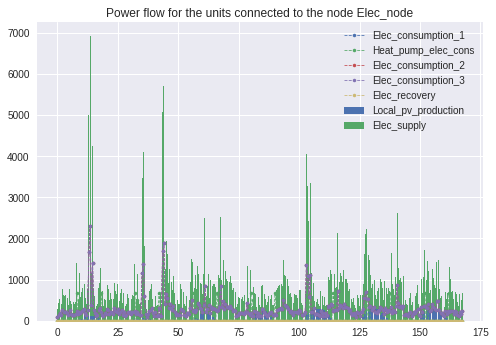


Preparing to plot the energy flows through the node Heat_node_dwelling1.
	Add power from Heat_pump_therm_prod.
	Add power from Heat_consumption_1.


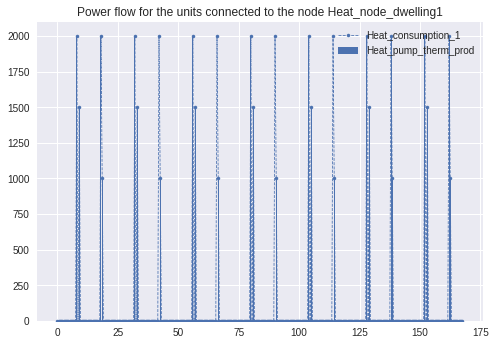

In [9]:
print("Number of pv panels installed = {}".format(local_pv_production.nb_unit))

plot_node_energetic_flows(elec_node).show()
plot_node_energetic_flows(heat_node_dwelling1).show()


### Additional indicators:
Here, global indicators are given. The described the total amount of energy produced/consummed by each element over the week.

In [10]:
print('Elec_consumption_1 = {0} kWh.'.format(elec_consumption_1.e_tot))
print('Elec_consumption_2 = {0} kWh.'.format(elec_consumption_2.e_tot))
print('Elec_consumption_3 = {0} kWh.'.format(elec_consumption_3.e_tot))
print('Heat_consumption_1 = {0} kWh.'.format(heat_consumption_1.e_tot))
print('Heat_consumption_2 = {0} kWh.'.format(heat_consumption_2.e_tot))
print('Heat_consumption_3 = {0} kWh.'.format(heat_consumption_3.e_tot))
print('Local_pv_production = {0} kWh'.format(local_pv_production.e_tot))
print('HeatPump consumption = {0} kWh'.format(heat_pump.elec_consumption_unit.e_tot))
print('Elec_supply = {0} kWh'.format(elec_supply.e_tot))
print('Elec_recovery = {0} kWh'.format(elec_recovery.e_tot))

Elec_consumption_1 = 48115.0 kWh.
Elec_consumption_2 = 48115.0 kWh.
Elec_consumption_3 = 48115.0 kWh.
Heat_consumption_1 = 22750.0 kWh.
Heat_consumption_2 = 22750.0 kWh.
Heat_consumption_3 = 22750.0 kWh.
Local_pv_production = 10845.3 kWh
HeatPump consumption = 7583.3333 kWh
Elec_supply = 141083.03 kWh
Elec_recovery = 0.0 kWh


## 6) Scenario 2

In Scenario 2, the prosumers want to install exactly 50 kWc of PV modules (corresponding to 200 units). 

### 6.1) Modelling process

The modelling process of Section 5.1 is repeated for Scenario 2 (the minimum production time for the heat pump is still removed). See Section 5.1 for more details.

In [11]:
time = TimeUnit(periods=24 * 7 * 2, dt=0.5)

#Units
elec_consumption_1 = FixedConsumptionUnit(time, name='Elec_consumption_1',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_1 = FixedConsumptionUnit(time, name='Heat_consumption_1',
                        p=heat_consumption, energy_type='Thermal')

elec_consumption_2 = FixedConsumptionUnit(time, name='Elec_consumption_2',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_2 = FixedConsumptionUnit(time, name='Heat_consumption_2',
                        p=heat_consumption, energy_type='Thermal')

elec_consumption_3 = FixedConsumptionUnit(time, name='Elec_consumption_3',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_3 = FixedConsumptionUnit(time, name='Heat_consumption_3',
                        p=heat_consumption, energy_type='Thermal')

local_pv_production = SeveralProductionUnit(time=time,
                                            name='Local_pv_production',
                                            fixed_prod=pv_production,
                                            energy_type='Electrical')

heat_pump = HeatPump(time=time, name='Heat_pump')

elec_supply = VariableProductionUnit(time=time, name='Elec_supply',
                                     energy_type='Electrical')
elec_recovery = VariableConsumptionUnit(time=time,
                                        name='Elec_recovery',
                                        energy_type='Electrical')

#Nodes
elec_node = EnergyNode(time=time, name='Elec_node',
                       energy_type='Electrical')

elec_node.connect_units(elec_consumption_1,
                        heat_pump.elec_consumption_unit,
                        elec_consumption_2,
                        elec_consumption_3,
                        local_pv_production,
                        elec_supply, elec_recovery)

heat_node_dwelling1 = EnergyNode(time=time, name='Heat_node_dwelling1',
                                 energy_type='Thermal')
heat_node_dwelling1.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_1)

heat_node_dwelling2 = EnergyNode(time=time, name='Heat_node_dwelling2',
                                 energy_type='Thermal')
heat_node_dwelling2.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_2)

heat_node_dwelling3 = EnergyNode(time=time, name='Heat_node_dwelling3',
                                 energy_type='Thermal')
heat_node_dwelling3.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_3)

#Actors
prosumer = Prosumer(name='Prosumer',
                     operated_consumption_unit_list=[elec_consumption_1,
                                                     elec_consumption_2,
                                                     elec_consumption_3],
                     operated_production_unit_list=[local_pv_production],
                     operated_storage_unit_list=[])

supplier = Supplier(name='Supplier',
                    operated_consumption_unit_list=[elec_recovery],
                    operated_production_unit_list=[elec_supply])

# The supplier does not want any injection on the network
supplier.add_energy_collected_maximum(max_e_tot=0,cst_operated_unit_list=[elec_recovery])

## The prosumer wants the heat pump to fonction at least 1 hour once it is started-up (2 time steps of half-an-hour).
#heat_pump.elec_consumption_unit._add_min_time_on(min_time_on=2)

# Scenario 2: the prosumer wants 200 modules of 250 Wc PV pannels corresponding to around 50kWc
prosumer.add_nb_unit_maximum(nb_unit_max=200,energy_unit=local_pv_production)
prosumer.add_nb_unit_minimum(nb_unit_min=200,energy_unit=local_pv_production)

prosumer.maximize_production(obj_operated_unit_list=[local_pv_production])

#Model and optimisation
model = OptimisationModel(time=time,name='article_2020_IBPSA_constraints_identification')

model.add_nodes_and_actors(elec_node,
                           heat_node_dwelling1,
                           heat_node_dwelling2,
                           heat_node_dwelling3,
                           prosumer, supplier)

model.solve_and_update()

print('\n OPTIMIZATION RESULT:', LpStatus[model.status])


You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:30:00
Creating the Elec_consumption_1.
Creating the Heat_consumption_1.
Creating the Elec_consumption_2.
Creating the Heat_consumption_2.
Creating the Elec_consumption_3.
Creating the Heat_consumption_3.
Creating the Local_pv_production.
Creating the Heat_pump_therm_prod.
Creating the Heat_pump_therm_cons.
Creating the Heat_pump_elec_cons.
Creating the Heat_pump.
Creating the Elec_supply.
Creating the Elec_recovery.
Creating the Elec_node.
Creating the Heat_node_dwelling1.
Creating the Heat_node_dwelling2.
Creating the Heat_node_dwelling3.
Creating the Prosumer.
Creating the Supplier.

--- Adding all variables to the model ---
Adding variable : Elec_consumption_1_p
Adding variable : Elec_consumption_1_e_tot
Adding variable : Heat_pump_elec_cons_p
Adding variable : Heat_pump_elec_cons_e_tot
Adding variable : Heat_pump_elec_cons_u
Adding variable : Elec_consumption_2_p
Adding variable : Elec_consumption_2_e_tot
Adding 

### 6.2) Infeasible problem : application of the lpfics module

Here the problem becomes unfeasible again. The lpfics module can be used to reveal a set of constraints that make the problem unfeasible.

In [12]:
# Adding time to evaluate the time of the identification
LPFICS_start = pytime.time()

# Basic lpfics algorithm
lpfics.find_infeasible_constraint_set(model)

LPFICS_time = pytime.time()
print('LPFICS duration', LPFICS_time - LPFICS_start)


With LPFICS:
Testing if the project is feasible.
If not, finding a set of constraints leading to the infeasibility

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/b5c8a49ed36c41fd8d4798590fac9f09-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/b5c8a49ed36c41fd8d4798590fac9f09-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3205 COLUMNS
At line 14166 RHS
At line 17367 BOUNDS
At line 20065 ENDATA
Problem MODEL has 3200 rows, 2697 columns and 8269 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.02 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 366 strengthened rows, 11728 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 61 strengthened rows, 4001 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitut

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/f06f269df21143019e0d83581fa32b6e-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/f06f269df21143019e0d83581fa32b6e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4804 COLUMNS
At line 18121 RHS
At line 22921 BOUNDS
At line 26376 ENDATA
Problem MODEL has 4799 rows, 3454 columns and 10455 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.01 seconds
Cgl0004I processed model has 672 rows, 672 columns (336 integer (336 of which binary)) and 1344 elements
Cbc0045I No integer variables out of 336 objects (336 integer) have costs
Cbc0045I branch on satisfied N create fake objective Y random cost Y
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 0
Cbc0038I Rela

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/760a627960f84353834b06a951883b5a-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/760a627960f84353834b06a951883b5a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4804 COLUMNS
At line 18082 RHS
At line 22882 BOUNDS
At line 26337 ENDATA
Problem MODEL has 4799 rows, 3454 columns and 10416 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.01 seconds
Cgl0004I processed model has 754 rows, 754 columns (377 integer (377 of which binary)) and 1508 elements
Cbc0045I No integer variables out of 377 objects (354 integer) have costs
Cbc0045I branch on satisfied N create fake objective Y random cost Y
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 0
Cbc0038I Rela

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/6e52b43a4dde401a8ad89895120409bb-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/6e52b43a4dde401a8ad89895120409bb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4404 COLUMNS
At line 17631 RHS
At line 22031 BOUNDS
At line 25654 ENDATA
Problem MODEL has 4399 rows, 3622 columns and 10031 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.02 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.05   (Wallclock seconds):       0.06

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/2692449bcd7a49168da0dbfcadd7b34a-pulp.mps timeMode elaps

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/f81f8bf97f9a43d68894f3110a09a2c6-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/f81f8bf97f9a43d68894f3110a09a2c6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2005 COLUMNS
At line 8623 RHS
At line 10624 BOUNDS
At line 13337 ENDATA
Problem MODEL has 2000 rows, 2712 columns and 4766 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.01 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.03   (Wallclock seconds):       0.03

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/cb3e7f1ddd944afe9c17cae2a4a4ce88-pulp.mps timeMode elapsed

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/c5eb06b598634036ae6e1ac38789e816-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/c5eb06b598634036ae6e1ac38789e816-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1105 COLUMNS
At line 5149 RHS
At line 6250 BOUNDS
At line 8337 ENDATA
Problem MODEL has 1100 rows, 2086 columns and 3046 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.02

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/6cae80cfc0a74bbd8cd0dc347ea259ed-pulp.mps timeMode elapsed b

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/9f1c232804b64fd189debbe592f48b77-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/9f1c232804b64fd189debbe592f48b77-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 555 COLUMNS
At line 2675 RHS
At line 3226 BOUNDS
At line 4528 ENDATA
Problem MODEL has 550 rows, 1301 columns and 1798 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/bbfd3c5448b7464db2b0ee899baaefa1-pulp.mps timeMode elapsed bra

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/3faeb056f55e41cfa8e7db8dc8364094-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/3faeb056f55e41cfa8e7db8dc8364094-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 330 COLUMNS
At line 1868 RHS
At line 2194 BOUNDS
At line 3279 ENDATA
Problem MODEL has 325 rows, 1084 columns and 1350 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 c

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/8b23975bb01643b6ad3c373181360301-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/8b23975bb01643b6ad3c373181360301-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 192 COLUMNS
At line 1335 RHS
At line 1523 BOUNDS
At line 2393 ENDATA
Problem MODEL has 187 rows, 869 columns and 1047 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/798b2c360d1f47cfa5aa7ec3f11f6b8f-pulp.mps timeMode elapsed bran

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/a3ba3206937b48d08e829c6e6f5db173-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/a3ba3206937b48d08e829c6e6f5db173-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 99 COLUMNS
At line 994 RHS
At line 1089 BOUNDS
At line 1849 ENDATA
Problem MODEL has 94 rows, 759 columns and 849 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/50034f0f25c54076a8fdaf8f3778aac1-pulp.mps timeMode elapsed branch p

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/a3d1db0948b743f9822b82c6309ad723-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/a3d1db0948b743f9822b82c6309ad723-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 52 COLUMNS
At line 816 RHS
At line 864 BOUNDS
At line 1573 ENDATA
Problem MODEL has 47 rows, 708 columns and 756 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/aa8930849bbd47eeaea51d6bd665325f-pulp.mps timeMode elapsed branch pr

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/366c14be8135435bbcbee0919b9c77cb-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/366c14be8135435bbcbee0919b9c77cb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 770 RHS
At line 803 BOUNDS
At line 1503 ENDATA
Problem MODEL has 32 rows, 699 columns and 727 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/670fbb9e97604f1184c2529c6aa2fc3d-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/670fbb9e97604f1184c2529c6aa2fc3d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 23 COLUMNS
At line 731 RHS
At line 750 BOUNDS
At line 1437 ENDATA
Problem MODEL has 18 rows, 686 columns and 702 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/ca9be8b4c6914b5ab3d9276c8ec73ea8-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/ca9be8b4c6914b5ab3d9276c8ec73ea8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 366 RHS
At line 375 BOUNDS
At line 720 ENDATA
Problem MODEL has 8 rows, 344 columns and 349 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/4580316192284347a925a95ea70ef93b-pulp.mps timeMode elapsed branch prin

**Identifying a constraint to remove:** here, the lpfics module identifies two Actor constraints alongside the Definition constraints. The first one corresponds to Scenario 2 and imposes the number of PV modules to be at least 200. The second one corresponds to the Suppliers constraint that prohibits injection on the network. Hence, Scenario 2 can become feasible if the latter is removed.

### 6.3) Re-solving after constraint relaxation

The modelling process of Section 6.1 is repeated and modified accordingly: the constraint "add_energy_collected_maximum" is removed.  

In [13]:
time = TimeUnit(periods=24 * 7 * 2, dt=0.5)

#Units
elec_consumption_1 = FixedConsumptionUnit(time, name='Elec_consumption_1',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_1 = FixedConsumptionUnit(time, name='Heat_consumption_1',
                        p=heat_consumption, energy_type='Thermal')

elec_consumption_2 = FixedConsumptionUnit(time, name='Elec_consumption_2',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_2 = FixedConsumptionUnit(time, name='Heat_consumption_2',
                        p=heat_consumption, energy_type='Thermal')

elec_consumption_3 = FixedConsumptionUnit(time, name='Elec_consumption_3',
                        p=elec_consumption,energy_type='Electrical')

heat_consumption_3 = FixedConsumptionUnit(time, name='Heat_consumption_3',
                        p=heat_consumption, energy_type='Thermal')

local_pv_production = SeveralProductionUnit(time=time,
                                            name='Local_pv_production',
                                            fixed_prod=pv_production,
                                            energy_type='Electrical')

heat_pump = HeatPump(time=time, name='Heat_pump')

elec_supply = VariableProductionUnit(time=time, name='Elec_supply',
                                     energy_type='Electrical')
elec_recovery = VariableConsumptionUnit(time=time,
                                        name='Elec_recovery',
                                        energy_type='Electrical')

#Nodes
elec_node = EnergyNode(time=time, name='Elec_node',
                       energy_type='Electrical')

elec_node.connect_units(elec_consumption_1,
                        heat_pump.elec_consumption_unit,
                        elec_consumption_2,
                        elec_consumption_3,
                        local_pv_production,
                        elec_supply, elec_recovery)

heat_node_dwelling1 = EnergyNode(time=time, name='Heat_node_dwelling1',
                                 energy_type='Thermal')
heat_node_dwelling1.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_1)

heat_node_dwelling2 = EnergyNode(time=time, name='Heat_node_dwelling2',
                                 energy_type='Thermal')
heat_node_dwelling2.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_2)

heat_node_dwelling3 = EnergyNode(time=time, name='Heat_node_dwelling3',
                                 energy_type='Thermal')
heat_node_dwelling3.connect_units(heat_pump.thermal_production_unit,
                                  heat_consumption_3)

#Actors
prosumer = Prosumer(name='Prosumer',
                     operated_consumption_unit_list=[elec_consumption_1,
                                                     elec_consumption_2,
                                                     elec_consumption_3],
                     operated_production_unit_list=[local_pv_production],
                     operated_storage_unit_list=[])

supplier = Supplier(name='Supplier',
                    operated_consumption_unit_list=[elec_recovery],
                    operated_production_unit_list=[elec_supply])

# The supplier does not want any injection on the network
#supplier.add_energy_collected_maximum(max_e_tot=0,cst_operated_unit_list=[elec_recovery])

## The prosumer wants the heat pump to fonction at least 1 hour once it is started-up (2 time steps of half-an-hour).
#heat_pump.elec_consumption_unit._add_min_time_on(min_time_on=2)

# Scenario 2: the prosumer wants 200 modules of 250 Wc PV pannels corresponding to around 50kWc
prosumer.add_nb_unit_maximum(nb_unit_max=200,energy_unit=local_pv_production)
prosumer.add_nb_unit_minimum(nb_unit_min=200,energy_unit=local_pv_production)

prosumer.maximize_production(obj_operated_unit_list=[local_pv_production])

#Model and optimisation
model = OptimisationModel(time=time,name='article_2020_IBPSA_constraints_identification')

model.add_nodes_and_actors(elec_node,
                           heat_node_dwelling1,
                           heat_node_dwelling2,
                           heat_node_dwelling3,
                           prosumer, supplier)

model.solve_and_update()

print('\n OPTIMIZATION RESULT:', LpStatus[model.status])


You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:30:00
Creating the Elec_consumption_1.
Creating the Heat_consumption_1.
Creating the Elec_consumption_2.
Creating the Heat_consumption_2.
Creating the Elec_consumption_3.
Creating the Heat_consumption_3.
Creating the Local_pv_production.
Creating the Heat_pump_therm_prod.
Creating the Heat_pump_therm_cons.
Creating the Heat_pump_elec_cons.
Creating the Heat_pump.
Creating the Elec_supply.
Creating the Elec_recovery.
Creating the Elec_node.
Creating the Heat_node_dwelling1.
Creating the Heat_node_dwelling2.
Creating the Heat_node_dwelling3.
Creating the Prosumer.
Creating the Supplier.

--- Adding all variables to the model ---
Adding variable : Elec_consumption_1_p
Adding variable : Elec_consumption_1_e_tot
Adding variable : Heat_pump_elec_cons_p
Adding variable : Heat_pump_elec_cons_e_tot
Adding variable : Heat_pump_elec_cons_u
Adding variable : Elec_consumption_2_p
Adding variable : Elec_consumption_2_e_tot
Adding 

### 6.4) Results

### Optimal solution:
In the following, an optimal solution of the problem is given. Here, an optimal solution includes the number of PV installed and the energy balance of all nodes. Since all heat nodes are the same (same demand), only the energy balance of the first one is shown.

Number of pv panels installed = 200.0

Preparing to plot the energy flows through the node Elec_node.
	Add power from Elec_consumption_1.
	Add power from Heat_pump_elec_cons.
	Add power from Elec_consumption_2.
	Add power from Elec_consumption_3.
	Add power from Local_pv_production.
	Add power from Elec_supply.
	Add power from Elec_recovery.


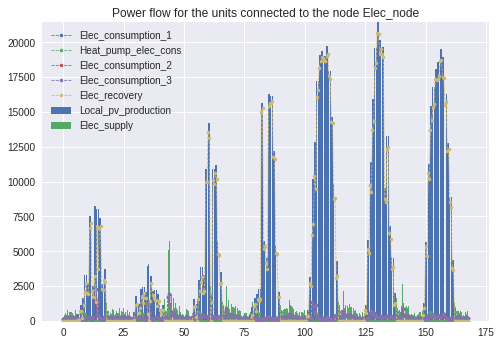


Preparing to plot the energy flows through the node Heat_node_dwelling1.
	Add power from Heat_pump_therm_prod.
	Add power from Heat_consumption_1.


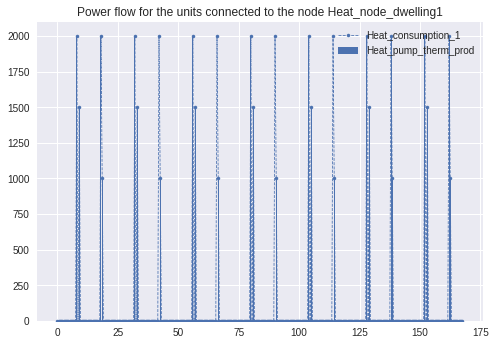

In [14]:
print("Number of pv panels installed = {}".format(local_pv_production.nb_unit))

plot_node_energetic_flows(elec_node).show()
plot_node_energetic_flows(heat_node_dwelling1).show()


### Additional indicators:
Here, global indicators are given. The described the total amount of energy produced/consummed by each element over the week.

In [15]:
print('Elec_consumption_1 = {0} kWh.'.format(elec_consumption_1.e_tot))
print('Elec_consumption_2 = {0} kWh.'.format(elec_consumption_2.e_tot))
print('Elec_consumption_3 = {0} kWh.'.format(elec_consumption_3.e_tot))
print('Heat_consumption_1 = {0} kWh.'.format(heat_consumption_1.e_tot))
print('Heat_consumption_2 = {0} kWh.'.format(heat_consumption_2.e_tot))
print('Heat_consumption_3 = {0} kWh.'.format(heat_consumption_3.e_tot))
print('Local_pv_production = {0} kWh'.format(local_pv_production.e_tot))
print('HeatPump consumption = {0} kWh'.format(heat_pump.elec_consumption_unit.e_tot))
print('Elec_supply = {0} kWh'.format(elec_supply.e_tot))
print('Elec_recovery = {0} kWh'.format(elec_recovery.e_tot))

Elec_consumption_1 = 48115.0 kWh.
Elec_consumption_2 = 48115.0 kWh.
Elec_consumption_3 = 48115.0 kWh.
Heat_consumption_1 = 22750.0 kWh.
Heat_consumption_2 = 22750.0 kWh.
Heat_consumption_3 = 22750.0 kWh.
Local_pv_production = 723020.0 kWh
HeatPump consumption = 7583.3333 kWh
Elec_supply = 64605.0 kWh
Elec_recovery = 635696.67 kWh


<a id='factsheet'></a>
## Factsheet
Notebook factsheet based on the [OEP scenario factsheet](https://openenergy-platform.org/factsheets/scenarios/)


<style type="text/css">
	table.tableizer-table {
		font-size: 12px;
		border: 1px solid #CCC; 
		font-family: Arial, Helvetica, sans-serif;
	} 
	.tableizer-table td {
		padding: 4px;
		margin: 3px;
		border: 1px solid #CCC;
	}
	.tableizer-table th {
		background-color: #104E8B; 
		color: #FFF;
		font-weight: bold;
	}
</style>
<table class="tableizer-table">
 <tr><td rowspan=21>Study</td>
 <tr><td>&nbsp;</td><td>Name</td><td>The lpfics module: practical application</td></tr>
 <tr><td>&nbsp;</td><td>Author - institution</td><td>Lou Morriet - G2Elab. Update : Etienne Cuisinier - G2Elab</td></tr>
 <tr><td>&nbsp;</td><td>Contact</td><td>etienne.cuisinier@g2elab.grenoble-inp.fr</td></tr>
 <tr><td>&nbsp;</td><td>Client</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Funding</td><td>Public</td></tr>
 <tr><td>&nbsp;</td><td>Citation reference</td><td>L. Morriet, B. Delinchant, G. Debizet, et F. Wurtz, « Algorithme d’identification de contraintes incompatibles pour les problèmes d’optimisation : application à un projet énergétique », p. 8, 2020.</td></tr>
 <tr><td>&nbsp;</td><td>Aim</td><td>This example shows how to use the lpfics module to find a set of constraints that makes an optimization problem unfeasible. It is illustrated on a modelling process of an energy system using the tool OMEGAlpes</td></tr>
 <tr><td>&nbsp;</td><td>New aspects</td><td></td></tr>
 <tr><td>&nbsp;</td><td>Spatial / Geographical coverage</td><td>Building scale / Grenoble</td></tr>
 <tr><td>&nbsp;</td><td>Time frame</td><td>2019</td></tr>
 <tr><td>&nbsp;</td><td>Tools</td><td>OMEGAlpes</td></tr>
 <tr><td>&nbsp;</td><td>Modeled energy sectors</td><td>Electricity, Heat</td></tr>
 <tr><td>&nbsp;</td><td>Modeled demand sectors</td><td>Households</td></tr>
 <tr><td>&nbsp;</td><td>Economic (behavioural) rationale </td><td>Single fictive decision-maker with perfect knowledge (perfect foresight optimization)</td></tr>
 <tr><td>&nbsp;</td><td>Technologies included </td><td>cristalline silicon PV, heat pump</td></tr>
 <tr><td>&nbsp;</td><td>Economic focuses included</td><td>No</td></tr>
 <tr><td>&nbsp;</td><td>Social focuses included</td><td>No</td></tr>
 <tr><td>&nbsp;</td><td>Endogenous variables</td><td>PV power, grid power, heat pump power, heat pump on/off and up/down status</td></tr>
 <tr><td>&nbsp;</td><td>Time steps</td><td>Half-an-hour</td></tr>
 <tr><td rowspan=7>Empirical data</td>
 <tr><td>&nbsp;</td><td>Exogenous time series used</td><td>Electric and heat loads, PV production</td></tr>
 <tr><td>&nbsp;</td><td>Technical data + usage</td><td>PV production, electrical and heat loads of dwellings ; PV and heat pump technical characteristics</td></tr>
 <tr><td>&nbsp;</td><td>Social data</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Economical data</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Ecological data</td><td>None</td></tr>
    <tr><td>&nbsp;</td><td>Pre-Processing</td><td>None</td></tr>
 <tr><td rowspan=5>Assumptions</td>
<tr><td>&nbsp;</td><td>Energy assumption</td><td>See Section 3</td></tr>
 <tr><td>&nbsp;</td><td>Environmental assumptions</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Economic assumption</td><td>None</td></tr> 
 <tr><td>&nbsp;</td><td>Post-processing</td><td>None</td></tr> 
 <tr><td rowspan=5>Results</td>
 <tr><td>&nbsp;</td><td>Uncertainty assesment</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Robustness</td><td>MILP optimizations lead with OMEGAlpes are robust and reproducible. If any issue is met with this tool, please indicate them in the Issues section of their gitlab.</td></tr>
 <tr><td>&nbsp;</td><td>Comparability / Validation</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Conclusions</td><td>The lpfics module can be used to identify sets of constraints that make an optimization problem infeasible. This can facilitate the modelling process of an energy system and can show what constraints are incompatible in a multi-actor model.</td></tr>
</tbody></table>